In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [5]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data15/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['MKD' 'ISL' 'IRL' 'ITA' 'GBR' 'AUT' 'FIN' 'NOR' 'PRT' 'BEL' 'EST' 'POL'
 'CHE' 'DNK' 'SWE']


,path,label
13261,/home/pascal_steiger/Downloads/data15/DNK/img_...,DNK
947,/home/pascal_steiger/Downloads/data15/MKD/img_...,MKD
9274,/home/pascal_steiger/Downloads/data15/BEL/img_...,BEL
4463,/home/pascal_steiger/Downloads/data15/GBR/img_...,GBR
14818,/home/pascal_steiger/Downloads/data15/SWE/img_...,SWE
2524,/home/pascal_steiger/Downloads/data15/IRL/img_...,IRL
4303,/home/pascal_steiger/Downloads/data15/GBR/img_...,GBR
5540,/home/pascal_steiger/Downloads/data15/AUT/img_...,AUT
11813,/home/pascal_steiger/Downloads/data15/POL/img_...,POL
11641,/home/pascal_steiger/Downloads/data15/POL/img_...,POL


In [6]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                    path label
534    /home/pascal_steiger/Downloads/data15/MKD/img_...   MKD
426    /home/pascal_steiger/Downloads/data15/MKD/img_...   MKD
1229   /home/pascal_steiger/Downloads/data15/ISL/img_...   ISL
14327  /home/pascal_steiger/Downloads/data15/SWE/img_...   SWE
11335  /home/pascal_steiger/Downloads/data15/POL/img_...   POL
(12012, 2)
                                                    path label
9441   /home/pascal_steiger/Downloads/data15/BEL/img_...   BEL
12437  /home/pascal_steiger/Downloads/data15/CHE/img_...   CHE
10707  /home/pascal_steiger/Downloads/data15/EST/img_...   EST
3210   /home/pascal_steiger/Downloads/data15/ITA/img_...   ITA
683    /home/pascal_steiger/Downloads/data15/MKD/img_...   MKD
(3003, 2)


In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

In [8]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(380, 380),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(380, 380),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 12012 validated image filenames belonging to 15 classes.
Found 3003 validated image filenames belonging to 15 classes.


In [9]:
with tf.device("/device:GPU:1"):
    from tensorflow.keras.applications import EfficientNetB4
    tl_efnet = EfficientNetB4(include_top=True,weights="imagenet")
    tl_efnet = tf.keras.Model(tl_efnet.input, tl_efnet.layers[-2].output)
    
    for layer in tl_efnet.layers:
        layer.trainable = False

    for layer in tl_efnet.layers[-5:]:
        layer.trainable = True 
    

In [10]:
tl_efnet.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [11]:
with tf.device("/device:GPU:1"):

    I = Input(shape=(380, 380, 3))



    x = tl_efnet(I)



    dense = Dense(1024, activation='relu', name='denserelu')(x)
    
    dropout = Dropout(0.1)(dense)

    dense2 = Dense(512, activation='relu', name='denserelu2')(dropout)
    
    dropout2 = Dropout(0.1)(dense2)

    dense3 = Dense(15, activation='softmax', name='my_dense')(dropout2)

    #prediction = Dense(26, activation='softmax', name='prediction')



    #out2 = prediction(x)


    new_model2 = tf.keras.Model(I, dense3)

    new_model2.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 1792)              17673823  
_________________________________________________________________
denserelu (Dense)            (None, 1024)              1836032   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
denserelu2 (Dense)           (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
my_dense (Dense)             (None, 15)                7695

In [12]:
def unwrap_model(model):
    mdl = model.get_layer('model')
    inp = mdl.input
    out = model.get_layer('denserelu')(mdl.output)
    out = model.get_layer('dropout')(out)
    out = model.get_layer('denserelu2')(out)
    out = model.get_layer('dropout_1')(out)
    out = model.get_layer('my_dense')(out)
    return tf.keras.Model(inp, out)   
    
new_model2 = unwrap_model(new_model2)

    
new_model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

Total params: 20,042,350
Trainable params: 3,174,927
Non-trainable params: 16,867,423
__________________________________________________________________________________________________


In [13]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [14]:
with tf.device("/device:GPU:1"):
    new_model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:1"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          validation_data=validation_generator)
    new_model2.save('CNN-TL_efficientNet-data7.h5')

Epoch 1/200
376/376 [==============================] - 471s 1s/step - loss: 1.9766 - sparse_categorical_accuracy: 0.3523 - val_loss: 1.7072 - val_sparse_categorical_accuracy: 0.4192
Epoch 2/200
376/376 [==============================] - 451s 1s/step - loss: 1.6543 - sparse_categorical_accuracy: 0.4515 - val_loss: 1.4908 - val_sparse_categorical_accuracy: 0.5012
Epoch 3/200
376/376 [==============================] - 455s 1s/step - loss: 1.5080 - sparse_categorical_accuracy: 0.4985 - val_loss: 1.4246 - val_sparse_categorical_accuracy: 0.5238
Epoch 4/200
376/376 [==============================] - 447s 1s/step - loss: 1.4051 - sparse_categorical_accuracy: 0.5251 - val_loss: 1.3874 - val_sparse_categorical_accuracy: 0.5358
Epoch 5/200
376/376 [==============================] - 449s 1s/step - loss: 1.3365 - sparse_categorical_accuracy: 0.5519 - val_loss: 1.4061 - val_sparse_categorical_accuracy: 0.5288
Epoch 6/200
376/376 [==============================] - 449s 1s/step - loss: 1.2647 - spars

Epoch 45/200
376/376 [==============================] - 456s 1s/step - loss: 0.2424 - sparse_categorical_accuracy: 0.9194 - val_loss: 1.4983 - val_sparse_categorical_accuracy: 0.6703
Epoch 46/200
376/376 [==============================] - 451s 1s/step - loss: 0.2431 - sparse_categorical_accuracy: 0.9143 - val_loss: 1.4916 - val_sparse_categorical_accuracy: 0.6710
Epoch 47/200
376/376 [==============================] - 450s 1s/step - loss: 0.2355 - sparse_categorical_accuracy: 0.9192 - val_loss: 1.4742 - val_sparse_categorical_accuracy: 0.6723
Epoch 48/200
376/376 [==============================] - 453s 1s/step - loss: 0.2271 - sparse_categorical_accuracy: 0.9241 - val_loss: 1.5223 - val_sparse_categorical_accuracy: 0.6697
Epoch 49/200
376/376 [==============================] - 450s 1s/step - loss: 0.2261 - sparse_categorical_accuracy: 0.9228 - val_loss: 1.5255 - val_sparse_categorical_accuracy: 0.6740
Epoch 50/200
376/376 [==============================] - 448s 1s/step - loss: 0.2208 -

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


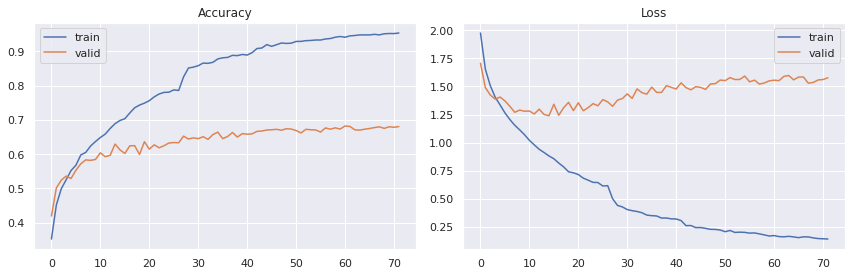

In [18]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(380,380)-tl_efficientnet-data15.png')

plt.show()

In [20]:
with tf.device("/device:GPU:1"):
    model2 = tf.keras.models.load_model('CNN-TL_efficientNet-data15.h5')

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=3003
batch_size=32
with tf.device("/device:GPU:1"):
    Y_pred = model2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = sorted(labelStringArr)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[113   3   6  12   3   2   1   3   2   9   3   8   7   2   1]
 [  8 103   6  15   6   3  22  17   1  12   1   2  15   1   5]
 [  8   5 152   4   0   6   6   1   0   1   2   5   6   0   1]
 [ 13   6   1 114  10   1   5   6   2   4   0   4   6   1   4]
 [  4   4   0   2 172   1   0   0   0   0   0   1   5   1   8]
 [  1   0   0   1   2 163   2   1   1   3   0   8   0   1   5]
 [  3  22   1  20   4   4  89  41   5   7   1   0   4   3   2]
 [  1  12   0  13   0   1  27 139   1   4   1   4   0   2   3]
 [  3   3   0   0   1   1   1   0 180   0   0   0   1   1   1]
 [ 13  14   6  13   4   7   5   5   0 100  16   3   9  21   5]
 [  1   2   3   0   4   0   1   0   2   6 158   1  13   7   2]
 [  8   6   1   3   1  12   2   5   1   2   1 133   1   2  28]
 [  6  10   1   7   9   2   4   2   0   5   1   3 129   1   3]
 [  4   3   4   5   0   2   0   2   0  16   6   1   1 181   5]
 [  6   6   2  10  17  12   4   0   0   2   1  15   7   1 122]]
Classification Report
              p